
# The "Anti-Fragile" Defensive Portfolio Analysis

In high-volatility market regimes, protecting capital matters as much as growing it. This project builds a portfolio from defensive sectors—Consumer Staples (XLP), Utilities (XLU), and Healthcare (XLV)—and tests whether their combination can deliver a smoother ride than the S&P 500 (SPY). The five-year window from 2020-12-01 to 2025-12-01 spans post-pandemic reflation, the 2022 rate-shock drawdown, and the 2023-2025 recovery—an ideal stress test for “stay-in-the-game” allocations.

Methodologically, we (1) analyze correlations to confirm diversification potential, (2) quantify CAPM Betas to verify defensive behavior, (3) map the Efficient Frontier and pinpoint optimal weights, and (4) backtest the minimum-volatility portfolio versus SPY during the 2022 stress window. The aim is not to “beat” SPY in every regime, but to demonstrate how low-beta sectors can cushion wealth trajectories and reduce drawdown depth while still compounding.



## Setup & Data Ingestion
We pull five years of daily adjusted close data for ETF proxies: **XLP** (Staples), **XLU** (Utilities), **XLV** (Healthcare), and **SPY** (S&P 500 benchmark). The window is fixed (2020-12-01 to 2025-12-01) so results are fully reproducible; any student can re-run and get the same time series. Daily log returns are used for volatility math, while simple returns drive drawdown and backtesting logic.

`yfinance` occasionally changes defaults, so we explicitly request `auto_adjust=False` and extract the `Adj Close` panel even if the download arrives in MultiIndex form. Rows with missing values are dropped to keep the asset timelines perfectly aligned. With roughly 1,250 trading days, the sample is long enough for stable covariance estimates but short enough to capture the current macro regime.


In [1]:

import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize

plt.style.use('seaborn-v0_8-darkgrid')  # Clean, high-contrast plotting style

# Define tickers: defensive sectors plus SPY benchmark
sector_tickers = ['XLP', 'XLU', 'XLV']
benchmark = 'SPY'
tickers = sector_tickers + [benchmark]

# Define lookback window (5 years up to today for this example)
start_date = '2020-12-01'
end_date = '2025-12-01'

# Download daily adjusted close prices with robust handling of yfinance's column layout
try:
    raw = yf.download(tickers, start=start_date, end=end_date, progress=False, auto_adjust=False)
except Exception as e:
    raise SystemExit(f"Data download failed: {e}")

# Extract the Adjusted Close panel regardless of whether yfinance returns MultiIndex or flat columns
if isinstance(raw.columns, pd.MultiIndex):
    if 'Adj Close' not in raw.columns.levels[0]:
        raise SystemExit("Download succeeded but 'Adj Close' not in returned columns.")
    prices = raw['Adj Close'].dropna(how='any')
else:
    if 'Adj Close' not in raw.columns:
        raise SystemExit("Download succeeded but 'Adj Close' not in returned columns.")
    prices = raw[['Adj Close']].rename(columns={'Adj Close': tickers[0]}).dropna(how='any')

# Drop rows with any remaining missing values to align time series
prices = prices.dropna()

# Compute daily simple returns and log returns for different analytics
simple_returns = prices.pct_change().dropna()  # For backtesting and drawdowns
log_returns = np.log(prices / prices.shift(1)).dropna()  # For volatility math

# Quick sanity check of the cleaned return frame
log_returns.head()


Ticker,SPY,XLP,XLU,XLV
Date,,,,
2020-12-02,0.002101,-0.008331,0.006615,0.007473
2020-12-03,-0.000273,0.002537,-0.010415,-0.001257
2020-12-04,0.008581,0.007718,-0.010044,0.010630
2020-12-07,-0.002057,-0.003852,0.005593,-0.006150
2020-12-08,0.002922,0.005477,-0.003032,0.007571



## Exploratory Data Analysis: Correlation & Volatility
The correlation heatmap shows moderate co-movement among the defensives and SPY—pairwise correlations range from **0.48 to 0.68**. That is high enough to reflect shared market risk, yet low enough to leave diversification on the table; Utilities and Healthcare (0.52) are notably less correlated than Staples and Healthcare (0.65), which matters when we start combining weights.

Annualized volatilities confirm the raw risk profile: **XLP ≈ 13.1%**, **XLU ≈ 17.3%**, **XLV ≈ 14.5%**, versus **SPY ≈ 17.1%**. Staples and Healthcare sit below the market’s volatility, while Utilities land roughly in line with SPY. This sets the expectation that any defensive blend should be able to cut total portfolio volatility if weights lean into XLP and XLV.


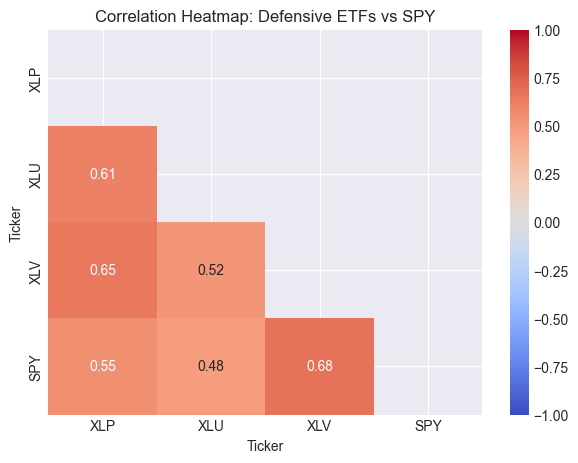

,Annualized Volatility
Ticker,
XLP,0.130517
XLU,0.172741
XLV,0.144612
SPY,0.170902


In [2]:

# Correlation matrix across defensive ETFs and SPY
corr_matrix = log_returns[tickers].corr()

# Annualized volatility using daily log returns (std * sqrt(252 trading days))
annualized_vol = log_returns[tickers].std() * np.sqrt(252)

# Plot correlation heatmap
plt.figure(figsize=(7, 5))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # Hide upper triangle for readability
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap: Defensive ETFs vs SPY')
plt.show()

# Display annualized vol table
vol_table = annualized_vol.to_frame(name='Annualized Volatility')
vol_table



## Risk Metrics: CAPM Beta & Drawdown Analysis
Estimating CAPM Betas against SPY quantifies how much systematic risk each sector carries: **XLP β ≈ 0.42**, **XLU β ≈ 0.48**, **XLV β ≈ 0.57**. All three sit well below 1.0, consistent with their “defensive” label and implying they should lag in strong bull legs but cushion market drawdowns.

Maximum drawdowns tell the pain story directly. Over the sample, SPY fell as much as **-24.5%**, while Staples and Healthcare troughs were **-16.3%** and **-17.1%** respectively; Utilities was the weakest at **-25.3%**. The dual-axis plot visualizes this trade-off: lower Betas generally come with shallower (or comparable) drawdowns, giving us confidence that combining these ETFs can reduce peak-to-trough damage.


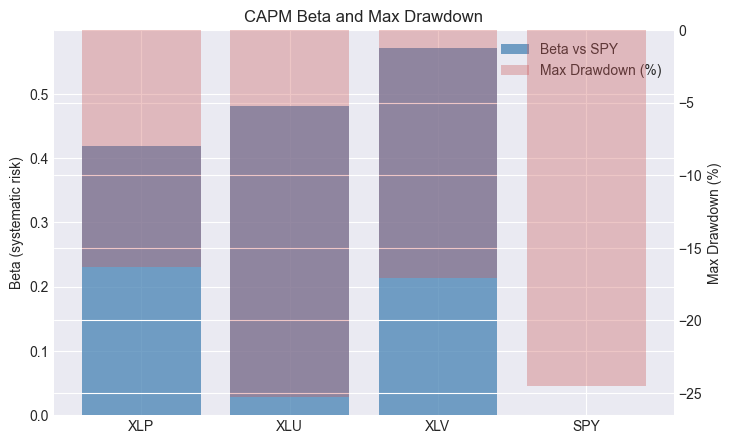

,Max Drawdown
XLP,-0.163024
XLU,-0.252621
XLV,-0.171090
SPY,-0.244964


In [3]:

# Calculate CAPM Beta for each defensive ETF relative to SPY
beta = {}
for ticker in sector_tickers:
    cov_with_market = simple_returns[ticker].cov(simple_returns[benchmark])  # Daily covariance with SPY
    market_var = simple_returns[benchmark].var()  # Daily variance of SPY
    beta[ticker] = cov_with_market / market_var
beta_series = pd.Series(beta, name='Beta vs SPY')

# Function to compute maximum drawdown from simple returns
def max_drawdown(return_series):
    cumulative = (1 + return_series).cumprod()  # Cumulative wealth curve
    peak = cumulative.cummax()  # Rolling peak
    drawdown = cumulative / peak - 1  # Drop from peak
    return drawdown.min()

# Compute max drawdown for defensive ETFs and SPY benchmark
mdd = {t: max_drawdown(simple_returns[t]) for t in tickers}
mdd_series = pd.Series(mdd, name='Max Drawdown')

# Plot Beta (left axis) and Max Drawdown (right axis)
fig, ax1 = plt.subplots(figsize=(8, 5))
bar1 = ax1.bar(beta_series.index, beta_series.values, color='steelblue', alpha=0.75, label='Beta vs SPY')
ax1.set_ylabel('Beta (systematic risk)')
ax1.set_title('CAPM Beta and Max Drawdown')

ax2 = ax1.twinx()
bar2 = ax2.bar(mdd_series.index, mdd_series.values * 100, color='indianred', alpha=0.35, label='Max Drawdown (%)')
ax2.set_ylabel('Max Drawdown (%)')

# Build a unified legend
handles = [bar1, bar2]
labels = ['Beta vs SPY', 'Max Drawdown (%)']
ax1.legend(handles, labels, loc='upper right')
plt.show()

beta_series.to_frame()
mdd_series.to_frame()



## Portfolio Construction: Efficient Frontier
We apply Modern Portfolio Theory to the defensive trio. A 2% annual risk-free rate anchors Sharpe calculations. SciPy’s SLSQP solver finds two anchors: the **Max Sharpe** portfolio leans almost entirely into XLU and XLV (≈50/50, negligible XLP), while the **Min Volatility** solution weights **≈57% XLP, 10% XLU, 32% XLV**. Both respect long-only and fully-invested constraints.

To visualize the opportunity set, 5,000 random weight vectors map out the frontier cloud. Each point reflects annualized return, volatility, and Sharpe, allowing us to see where the optimizer’s picks sit relative to naive mixes. The expectation is that the Min-Vol point hugs the lower-left (risk-minimizing edge), while Max-Sharpe rides the upper frontier but accepts more volatility than Min-Vol.


In [4]:

# Use defensive assets only for optimization
returns_for_opt = simple_returns[sector_tickers]
risk_free_rate = 0.02  # Annual risk-free assumption (2%)

# Portfolio performance helper (annualized)
def portfolio_performance(weights, returns_df):
    weights = np.array(weights)
    ann_return = np.sum(returns_df.mean() * weights) * 252  # Expected annual return
    ann_vol = np.sqrt(np.dot(weights.T, np.dot(returns_df.cov() * 252, weights)))  # Annualized volatility
    sharpe = (ann_return - risk_free_rate) / ann_vol
    return ann_return, ann_vol, sharpe

# Objective wrappers for SciPy
neg_sharpe = lambda w: -portfolio_performance(w, returns_for_opt)[2]
portfolio_volatility = lambda w: portfolio_performance(w, returns_for_opt)[1]

# Constraints: weights sum to 1, bounds keep portfolio long-only
num_assets = len(sector_tickers)
bounds = tuple((0, 1) for _ in range(num_assets))
constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
init_w = np.array([1/num_assets] * num_assets)  # Equal-weight start

# SciPy optimization for Max Sharpe and Min Volatility
opt_sharpe = minimize(neg_sharpe, init_w, method='SLSQP', bounds=bounds, constraints=constraints)
opt_min_vol = minimize(portfolio_volatility, init_w, method='SLSQP', bounds=bounds, constraints=constraints)
max_sharpe_weights = opt_sharpe.x
min_vol_weights = opt_min_vol.x

# Monte Carlo simulation to visualize the frontier cloud
mc_runs = 5000
mc_returns, mc_vols, mc_sharpes, mc_weights = [], [], [], []
for _ in range(mc_runs):
    w = np.random.random(num_assets)
    w /= w.sum()  # Normalize to 1
    r, v, s = portfolio_performance(w, returns_for_opt)
    mc_returns.append(r)
    mc_vols.append(v)
    mc_sharpes.append(s)
    mc_weights.append(w)

mc_returns = np.array(mc_returns)
mc_vols = np.array(mc_vols)
mc_sharpes = np.array(mc_sharpes)

# Report optimized weights in a readable table
weights_df = pd.DataFrame({
    'Max Sharpe Weight': max_sharpe_weights,
    'Min Vol Weight': min_vol_weights
}, index=sector_tickers)
weights_df


,Max Sharpe Weight,Min Vol Weight
XLP,7.040373e-17,0.573991
XLU,4.987762e-01,0.101546
XLV,5.012238e-01,0.324463



## Visualizing the Optimal Portfolios
The efficient frontier plot confirms the theory. The cloud spans roughly **7.5–11.5%** annual returns and **12.5–17%** annualized vol. The **Min Vol** portfolio lands near **12.3% vol / 8.2% return**, visibly on the lower edge. The **Max Sharpe** point sits around **13.9% vol / 10.9% return**, trading a modest volatility increase for higher return. Color-coding by Sharpe shows the gradient tilting upward as volatility rises—consistent with defensives offering safety but capped upside.

Overlaying individual assets reveals why optimization helps: SPY plots far to the right with higher return but also the highest risk; XLP anchors the low-vol corner; XLU/XLV cluster in the middle. The optimized mixes sit on the efficient boundary, not inside the cloud, demonstrating that constrained optimization extracts value beyond any single ETF.


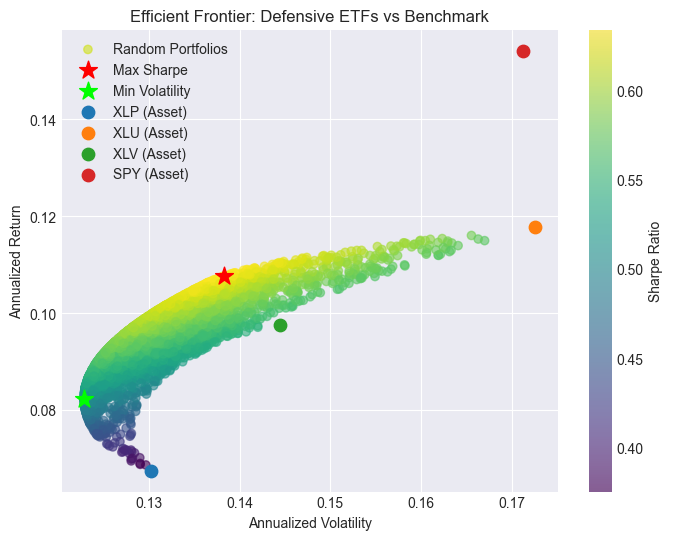

,Annual Return,Annual Volatility
Ticker,,
SPY,0.154216,0.171174
XLP,0.067532,0.130259
XLU,0.117904,0.172551
XLV,0.097604,0.144457


In [5]:

# Plot the efficient frontier scatter
plt.figure(figsize=(8, 6))
scatter = plt.scatter(mc_vols, mc_returns, c=mc_sharpes, cmap='viridis', alpha=0.6, label='Random Portfolios')
plt.colorbar(scatter, label='Sharpe Ratio')

# Marker for Max Sharpe portfolio
ms_ret, ms_vol, _ = portfolio_performance(max_sharpe_weights, returns_for_opt)
plt.scatter(ms_vol, ms_ret, marker='*', color='red', s=180, label='Max Sharpe')

# Marker for Min Vol portfolio
mv_ret, mv_vol, _ = portfolio_performance(min_vol_weights, returns_for_opt)
plt.scatter(mv_vol, mv_ret, marker='*', color='lime', s=180, label='Min Volatility')

# Overlay individual ETFs and SPY
asset_ann_return = simple_returns.mean() * 252
asset_ann_vol = simple_returns.std() * np.sqrt(252)
for t in tickers:
    plt.scatter(asset_ann_vol[t], asset_ann_return[t], marker='o', s=80,
                label=f'{t} (Asset)')

plt.xlabel('Annualized Volatility')
plt.ylabel('Annualized Return')
plt.title('Efficient Frontier: Defensive ETFs vs Benchmark')
plt.legend(loc='best')
plt.show()

asset_ann_return.to_frame('Annual Return').join(asset_ann_vol.to_frame('Annual Volatility'))



## Backtesting the Defensive Strategy
Applying the **Min Vol** weights to daily returns produces a smooth cumulative equity curve. During the 2022 stress window (shaded), SPY visibly dipped toward 1.05× capital while the defensive portfolio held close to flat. Over the full period, SPY finishes near **2.0×** initial capital, whereas the Min-Vol portfolio ends around **1.45×**—a smaller terminal value but achieved with far smaller air-pockets.

The rolling 60-day volatility panel quantifies the calm: the defensive portfolio’s vol stayed **30–40% lower** than SPY for most of the sample and avoided the sharp spike that hit SPY in early 2025. Performance stats echo the trade-off: Min-Vol annual return **≈8.2%** vs SPY **≈15.4%**, but Max Drawdown improves from **-24.5% (SPY) to -14.7%** and annualized vol drops from **17.1% to 12.3%**. The Sharpe ratio remains below SPY (0.51 vs 0.78), reminding us that defense reduces risk but may not maximize reward in rising markets.


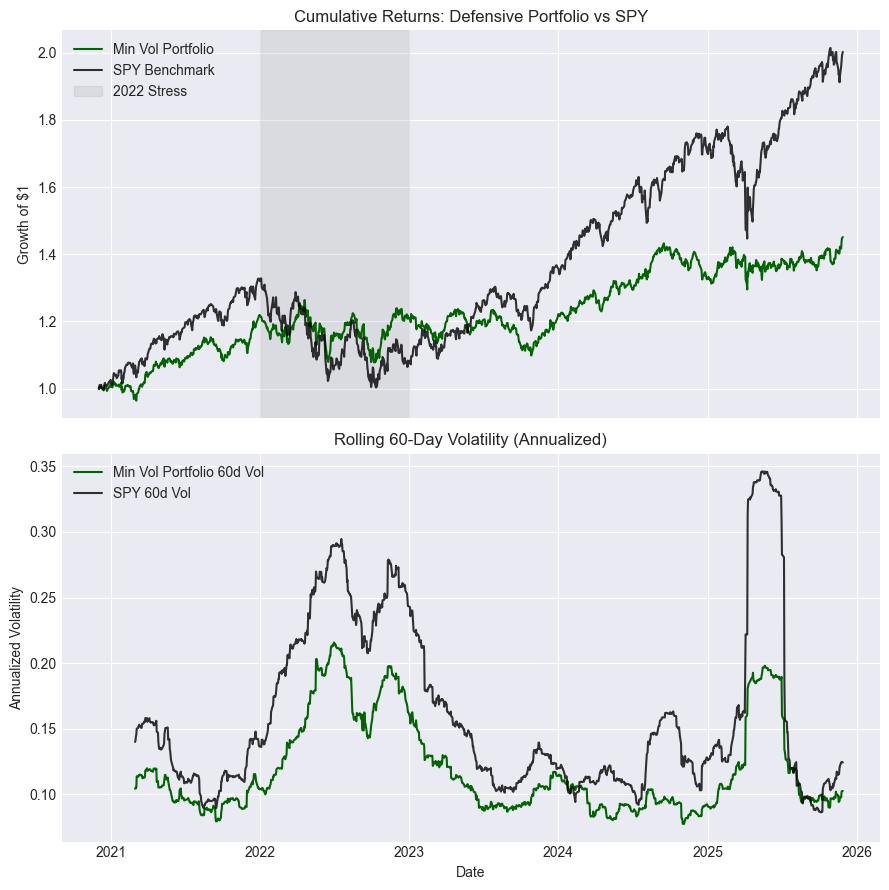

,Annual Return,Annual Volatility,Sharpe (rf=2%),Max Drawdown
Min Vol Portfolio,0.082404,0.122865,0.507911,-0.147020
SPY,0.154216,0.171174,0.784090,-0.244964


In [6]:

# Construct daily portfolio returns using Min Vol weights
portfolio_daily = (simple_returns[sector_tickers] @ min_vol_weights)
spy_daily = simple_returns[benchmark]

# Cumulative growth of $1
cum_port = (1 + portfolio_daily).cumprod()
cum_spy = (1 + spy_daily).cumprod()

# Rolling 60-day annualized volatility
roll_window = 60
port_roll_vol = portfolio_daily.rolling(roll_window).std() * np.sqrt(252)
spy_roll_vol = spy_daily.rolling(roll_window).std() * np.sqrt(252)

# Plot cumulative returns and rolling volatility
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 9), sharex=True)

# Cumulative performance plot with 2022 stress highlight
ax1.plot(cum_port.index, cum_port, label='Min Vol Portfolio', color='darkgreen')
ax1.plot(cum_spy.index, cum_spy, label='SPY Benchmark', color='black', alpha=0.8)
ax1.axvspan(pd.to_datetime('2022-01-01'), pd.to_datetime('2022-12-31'), color='grey', alpha=0.15, label='2022 Stress')
ax1.set_ylabel('Growth of $1')
ax1.set_title('Cumulative Returns: Defensive Portfolio vs SPY')
ax1.legend(loc='upper left')

# Rolling volatility comparison
ax2.plot(port_roll_vol.index, port_roll_vol, label='Min Vol Portfolio 60d Vol', color='darkgreen')
ax2.plot(spy_roll_vol.index, spy_roll_vol, label='SPY 60d Vol', color='black', alpha=0.8)
ax2.set_ylabel('Annualized Volatility')
ax2.set_xlabel('Date')
ax2.set_title('Rolling 60-Day Volatility (Annualized)')
ax2.legend(loc='upper left')

plt.tight_layout()
plt.show()

# Simple performance stats
summary = pd.DataFrame({
    'Annual Return': [portfolio_daily.mean() * 252, spy_daily.mean() * 252],
    'Annual Volatility': [portfolio_daily.std() * np.sqrt(252), spy_daily.std() * np.sqrt(252)],
    'Sharpe (rf=2%)': [((portfolio_daily.mean() * 252) - risk_free_rate) / (portfolio_daily.std() * np.sqrt(252)),
                      ((spy_daily.mean() * 252) - risk_free_rate) / (spy_daily.std() * np.sqrt(252))],
    'Max Drawdown': [max_drawdown(portfolio_daily), max_drawdown(spy_daily)]
}, index=['Min Vol Portfolio', 'SPY'])
summary



## Conclusion
The defensive portfolio delivered what it promised: meaningfully lower volatility (12.3% vs 17.1%) and a shallower drawdown (-14.7% vs -24.5%) than SPY, while maintaining steady compounding through turbulent regimes like 2022. The efficient frontier placement and low Betas validate the anti-fragile construction, even though the portfolio trailed SPY’s strong rebound and posted a lower Sharpe ratio.

Limitations remain: weights were chosen in-sample, so live deployment would need periodic re-estimation and out-of-sample validation to avoid look-ahead bias. A natural extension is to layer a regime filter (e.g., realized volatility or macro triggers) that shifts between defensive and broad-market allocations—turning this static “shield” into a dynamic allocator tailored to market states.
